In [128]:
%run './MapScore.ipynb'

In [2]:
%cd /content/drive/MyDrive/EdgeNeuralAi

/content/drive/MyDrive/EdgeNeuralAi


In [104]:
# importing the neccesary lib
import os , cv2 , glob , math , time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet # importing xml.etree for reading the xml files

# importing tensorflow libraries
from tensorflow.keras.models import Model , load_model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet152V2 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input

In [105]:
model = load_model('./object_detection_resnet.h5')

In [106]:
# get the IOu score between the prediction and ground truth
"""IOU is the metric in object detection . It is the area of intersection between the prediction and ground truth 
divide by the union area"""
def getIouScore(pred,grndt):
    x1_t,x2_t,y1_t,y2_t = grndt
    x1_p,x2_p,y1_p,y2_p = pred
    
# if the x1 truth is greater than x2 truth or y_truth1 is greater than ytruth2 then the truth values are wrong
    assert (x1_t < x2_t) and (y1_t < y2_t)
    
# if the x1 pred is greater than x2 pred or y_pred1 is greater than ypred2 then the prediction  is completely invalid
    assert (x1_p < x2_p) and (y1_p < y2_p)
    
# this condition defines their is no intersection area between pred and truth
    if x1_t > x2_p or x1_p > x2_t or y1_t > y2_p or y1_p > y2_t:
        return 0
    
    p1 = max(x1_t,x1_p) # left x point axis of intersection rectangular box 
    p2 = min(x2_t,x2_p) 
    p3 = max(y1_t,y1_p)
    p4 = min(y2_t,y2_p)
    intersection = max((p2-p1) * (p4-p3),0)
    union = (x2_t-x1_t)*(y2_t-y1_t) + (x2_p-x1_p)*(y2_p-y1_p) - intersection
    return intersection/union

def getcoordinate(filename):
    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)
    name= filename.replace('Annotations','JPEGImages').replace('xml','jpg')
    return [xmin,xmax,ymin,ymax]

def preprocessImage(url):
    image = cv2.imread(url)
    h,w,d = image.shape
    image = cv2.resize(image,(224,224))
    image = np.array(image).astype(np.float32)
    image = image/255.0
    return image

In [107]:
imageSet = dict({
    'names':[],
    'ground': [],
    'prediction':[]
})
prediction = []

In [116]:
st = time.time()

for img in glob.glob('./test/*.jpg'):
  img_name = img.split('/')[2].split('.')[0]
  image = cv2.imread(img)
  h,w = image.shape[:2]
  image = cv2.resize(image,(224,224))
  image = image/255.0
  pred = model.predict(np.expand_dims(image,axis=0))
  pred = pred * [w,w,h,h]
  pred = np.array(pred).astype(np.uint32)
  prediction.append(np.squeeze(pred))

et = time.time()

In [115]:
print("Time taken to make prediction is {0} sec".format(et-st))

Time taken to make prediction is 19.395146369934082 sec


In [109]:
for img in glob.glob('./test/*.jpg'):
  img_name = img.split('/')[2].split('.')[0]
  imageSet['names'].append(img_name)

  xml = './Annotations/{0}.xml'.format(img_name)
  imageSet['ground'].append(getcoordinate(xml))

  image = cv2.imread(img)
  h,w = image.shape[:2]
  image = cv2.resize(image,(224,224))
  image = image/255.0
  pred = model.predict(np.expand_dims(image,axis=0))
  pred = pred * [w,w,h,h]
  pred = np.array(pred).astype(np.uint32)
  prediction.append(np.squeeze(pred))

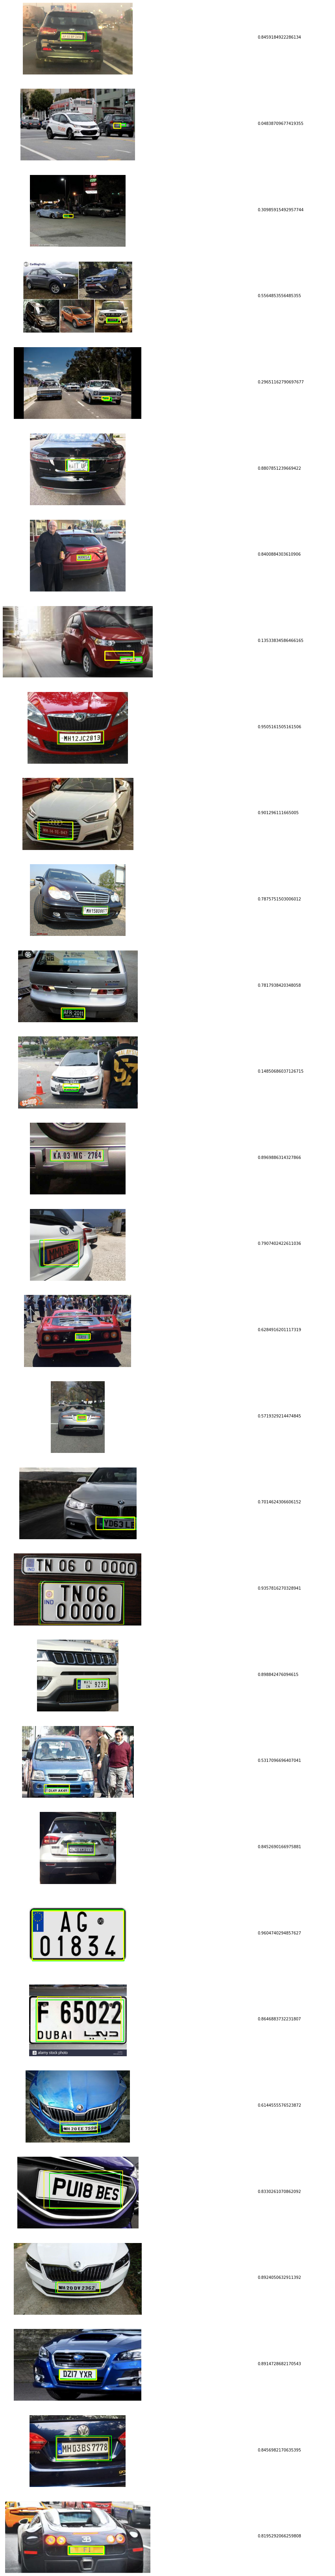

In [89]:
# plt.figure(figsize = )
fig,ax = plt.subplots(30,2,figsize=(15,120))
for i in range(len(imageSet['ground'])): 
  xmin_t , xmax_t , ymin_t , ymax_t = imageSet['ground'][i]
  xmin_p , xmax_p ,ymin_p,ymax_p = imageSet['prediction'][i]
  image = plt.imread('./test/{0}.jpg'.format(imageSet["names"][i]))
  image = cv2.rectangle(image,(xmin_t,ymin_t),(xmax_t,ymax_t),(0,255,0),2)
  image = cv2.rectangle(image,(xmin_p,ymin_p),(xmax_p,ymax_p),(255,255,0),2)
  iou_score = getIouScore(imageSet['ground'][i],imageSet['prediction'][i])
  ax[i,0].axis('off')
  ax[i,0].imshow(image)

  ax[i,1].axis('off')
  ax[i,1].text(0.5,0.5,iou_score)
  plt.axis('off')

In [130]:
xmls = glob.glob('./test/*.jpg')
pred_info={}
ground_info={}

In [124]:
for xml in xmls:
    img_url = xml.replace('Annotations','test').replace('xml','jpg')
    img_name = img_url.split('/')[-1]
    h,w = plt.imread(img_url).shape[:2]
    preprocessed_img = preprocessImage(img_url)
    pred = model.predict(np.expand_dims(preprocessed_img,axis=0))
    pred = pred * ([w,w,h,h])
    pred = np.squeeze(pred)
    pred_info[img_name] = [int(x) for x in pred]
    grnd = getcoordinate(xml)
    ground_info[img_name] = grnd
    

In [129]:
get_map_score(pred_info,ground_info)

0.6848484848484848